# Convolutional Neural Networks

## Dog breed classification using transfer learning



## Step 1: import dataset

Make sure that you've downloaded the required dog dataset:
* Download the dataset, unzip the folder and place it in this project's home directory, at the location `/dogs`. 

In [1]:
import numpy as np
from glob import glob

# load filenames
dog_files = np.array(glob("dogs/*/*/*"))

# print the number of images in the dataset
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


## Step 2: detect dogs

In this section, we will use a Pre-trained VGG16 Model to detect dogs.

The following code cell downloads the VGG16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a large, popular dataset used for image classification with 1000 categories.

In [ ]:
import torch
import torchvision.models as models
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# define Faster R-CNN model
model_faster_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)

# check if CUDA is available and move the model to GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_faster_rcnn = model_faster_rcnn.cuda()


### Using the pre-trained model

Next, we will write a function that accepts as input a path to an image, and returns an integer between 0 and 999 (inclusive), representing one of the 1000 possible classes.
Note that VGG16 requires an imput image size of 224x224.

In [3]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def faster_rcnn_predict(img_path, model):
    '''
    Use pre-trained Faster R-CNN model to detect objects in an image and 
    return predictions.
    
    Args:
        img_path: path to an image
        model: pre-trained Faster R-CNN model
        
    Returns:
        predictions: a list of dictionaries for detected objects, 
        each containing 'boxes', 'labels', and 'scores'
    '''

    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
            transforms.ToTensor()])
    image = transform(image).unsqueeze(0)  # Add batch dimension

    if use_cuda:
        image = image.cuda()
    
    model.eval()  # Set the model to inference mode
    with torch.no_grad():
        predictions = model(image)
    
    return predictions[0]  # Return predictions for the first image in batch



Among output classes, categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268 (inclusive).  Therefore, to verify whether a dog is detected, we only need to check if the pre-trained model predicts an index between 151 and 268.

The `dog_detector` function below returns `True` if a dog is detected in an image, and `False` if not.

In [4]:
def dog_detector(img_path, model):
    '''
    Use pre-trained Faster R-CNN model to detect dogs in an image.
    
    Args:
        img_path: path to an image
        model: pre-trained Faster R-CNN model
        
    Returns:
        bool: True if dogs are detected in the image, False otherwise
    '''
    predictions = faster_rcnn_predict(img_path, model)
    
    # Iterate through the detected objects
    for i in range(len(predictions['labels'])):
        # Check if the detected object is a dog
        # In COCO dataset, the label for dog is 18
        if predictions['labels'][i] == 18 and predictions['scores'][i] > 0.5:  # Adjust score threshold as needed
            return True
    return False


### Test your dog detector

In [5]:
dog_files_short = dog_files[:100]
count_dog_dog = 0

# Assuming model_faster_rcnn is your Faster R-CNN model initialized earlier
for img in dog_files_short:
    if dog_detector(img, model_faster_rcnn):
        count_dog_dog += 1

# Calculate the percentage of images with dogs detected
percentage_dogs_detected = (count_dog_dog / len(dog_files_short)) * 100

print(f'Dogs detected in {count_dog_dog} out of {len(dog_files_short)} images ({percentage_dogs_detected:.2f}%)')

Dogs detected in 93 out of 100 images (93.00%)


## Step 3: create a CNN to classify dog breeds using transfer learning
### Specify data loaders 

In the following code cell, we write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets (located at `dogs/train`, `dogs/valid`, and `dogs/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [6]:
import os
from torchvision import datasets

# Writing data loaders for training, validation, and test sets
# Specifying appropriate transforms, and batch_sizes
batch_size  = 20
num_workers = 0

img_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))  
    ])

train_data=datasets.ImageFolder('dogs/train', transform = img_transform)
validation_data=datasets.ImageFolder('dogs/valid', transform = img_transform)
test_data=datasets.ImageFolder('dogs/test', transform = img_transform)         

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

loaders_transfer = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}


### Model architecture

Transfer learning is used to create a CNN to classify dog breed.  The initialized model will be saved as the variable `model_transfer`.


In [ ]:
import torchvision.models as models
import torch.nn as nn

# model architecture 
model_transfer = models.vgg16(pretrained=True)
print(model_transfer)


When we print the model, we can see the model's architecture. The last fully-connected layer is at index 6 in the Classifier part of our CNN. Now will change change the number of ouputs from 1000 to 133, thus customizing the classification of VGG16 to our dataset of 133 possible dog breeds. We will also freeze the feature extraction part of our CNN.

In [8]:
model_transfer.classifier[6]=nn.Linear(model_transfer.classifier[6].in_features, 133)
for param in model_transfer.features.parameters():
    param.requires_grad = False #freeze CNN params from retraining

if use_cuda:
    model_transfer = model_transfer.cuda()

### Specify loss function and optimizer

The following code cell is used to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and an [optimizer](http://pytorch.org/docs/master/optim.html).  The chosen loss function is saved as `criterion_transfer`, and the optimizer as `optimizer_transfer`.

In [9]:
import torch.optim as optim

# Setup the loss function
criterion_transfer = torch.nn.CrossEntropyLoss()
# Configure the optimizer to update only the parameters of the final classifier layer
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.01)


### Train and validate the model

Now we will train and validate our model, and we will save the model parameters as save_path `'model_transfer.pt'`.

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # find the loss and update the model parameters accordingly
            # record the average training loss
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)     
            loss.backward()   
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss    
    # return trained model
    return model


# train the model
n_epochs = 100
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.431407 	Validation Loss: 1.429243
Validation loss decreased (inf --> 1.429243).  Saving model ...
Epoch: 2 	Training Loss: 1.461486 	Validation Loss: 1.266086
Validation loss decreased (1.429243 --> 1.266086).  Saving model ...
Epoch: 3 	Training Loss: 1.294430 	Validation Loss: 1.243111
Validation loss decreased (1.266086 --> 1.243111).  Saving model ...
Epoch: 4 	Training Loss: 1.241342 	Validation Loss: 1.205464
Validation loss decreased (1.243111 --> 1.205464).  Saving model ...
Epoch: 5 	Training Loss: 1.186622 	Validation Loss: 1.150134
Validation loss decreased (1.205464 --> 1.150134).  Saving model ...
Epoch: 6 	Training Loss: 1.123695 	Validation Loss: 1.145657
Validation loss decreased (1.150134 --> 1.145657).  Saving model ...
Epoch: 7 	Training Loss: 1.143289 	Validation Loss: 1.084216
Validation loss decreased (1.145657 --> 1.084216).  Saving model ...
Epoch: 8 	Training Loss: 1.110417 	Validation Loss: 1.094901
Epoch: 9 	Training Loss: 1.044255 

<All keys matched successfully>

### Test the model

Let's try out our model on the test dataset. We will calculate and print the test loss and accuracy.  

In [11]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.130548


Test Accuracy: 70% (593/836)


### Predict dog breed with the model

Let's write a function that takes an image path as input and returns the dog breed that is predicted by our model.  

In [22]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]



# Assuming class_names and use_cuda are defined globally

def predict_breed_transfer_multi_optimized(img_path, detection_model, classification_model):
    '''
    Optimized function to detect dogs in an image and predict the breed of each detected dog.
    
    Args:
        img_path: Path to an image.
        detection_model: Pre-trained Faster R-CNN model for dog detection.
        classification_model: Pre-trained model for dog breed classification.
        
    Returns:
        breeds: A list of predicted dog breeds for each detected dog in the image.
    '''
    # Load and transform the image
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move models and tensors to CUDA if available
    if use_cuda:
        image_tensor = image_tensor.cuda()
        detection_model = detection_model.cuda()
        classification_model = classification_model.cuda()

    detection_model.eval()
    classification_model.eval()

    with torch.no_grad():
        detections = detection_model(image_tensor)

    crops = []
    # Iterate over each detection, preparing crops for batched classification if detected object is a dog
    for i, label in enumerate(detections[0]['labels']):
        if label.item() == 18:  # Label 18 corresponds to dogs
            box = detections[0]['boxes'][i].cpu().numpy()
            crop = image.crop((box[0], box[1], box[2], box[3]))
            crops.append(crop)

    # Prepare crops for classification
    normalize = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    crops_tensors = torch.stack([normalize(crop) for crop in crops])  # Stack for batch processing

    if use_cuda:
        crops_tensors = crops_tensors.cuda()

    # Predict breeds in a single batch
    breed_outputs = classification_model(crops_tensors)
    predictions = breed_outputs.argmax(dim=1).tolist()

    detected_breeds = [class_names[prediction] for prediction in predictions]

    return detected_breeds




Now let us try with our own images. Create a folder named myImages and put inside some dog images that you obtain
from the internet (or from your smartphone camera if you own one or more dogs...)

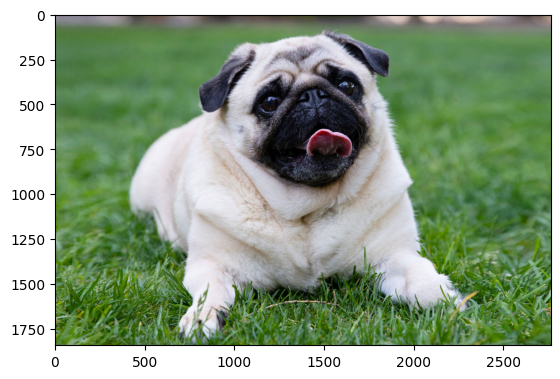

Detected dog breeds: Bulldog


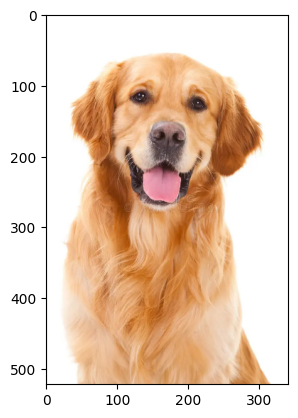

Detected dog breeds: Golden retriever


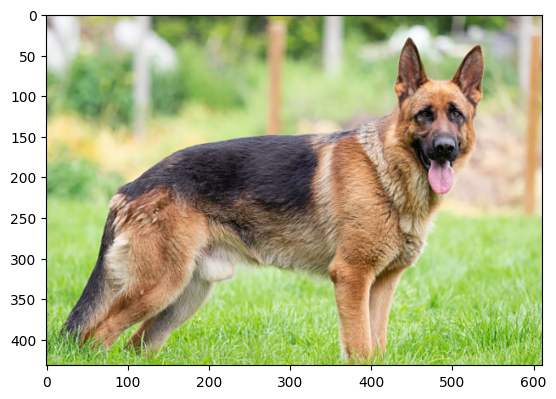

Detected dog breeds: German shepherd dog


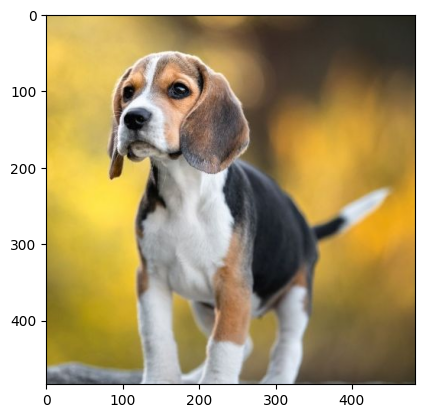

Detected dog breeds: Beagle


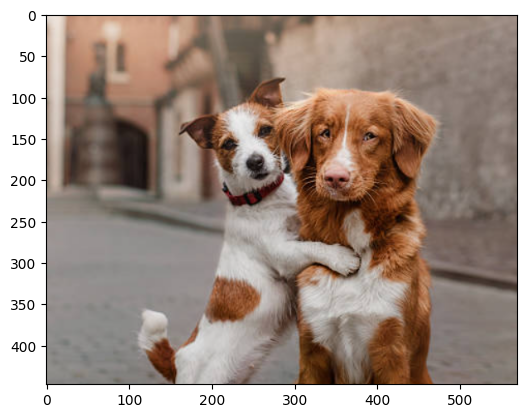

Detected dog breeds: Brittany, Nova scotia duck tolling retriever


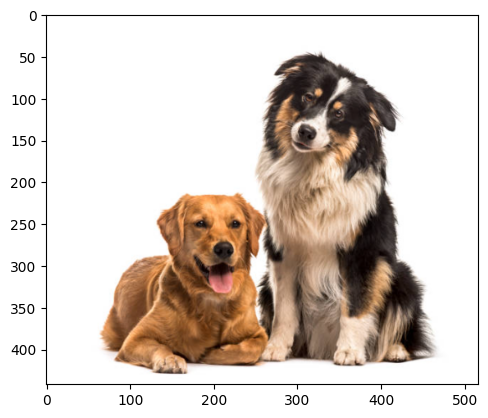

Detected dog breeds: Australian shepherd, Golden retriever


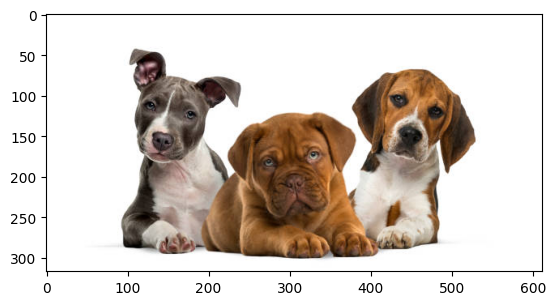

Detected dog breeds: American foxhound, Dogue de bordeaux, American staffordshire terrier


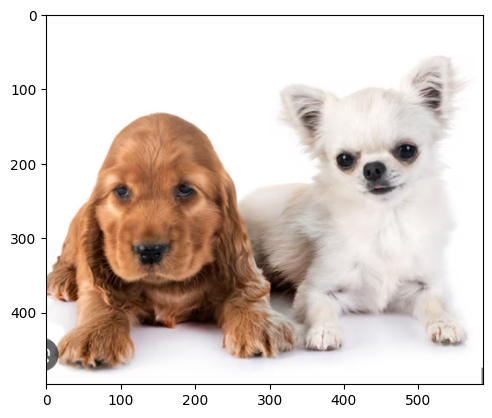

Detected dog breeds: English cocker spaniel, Chihuahua


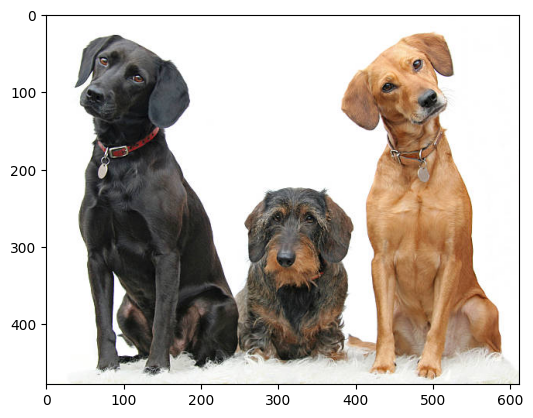

Detected dog breeds: Labrador retriever, Dachshund, Golden retriever


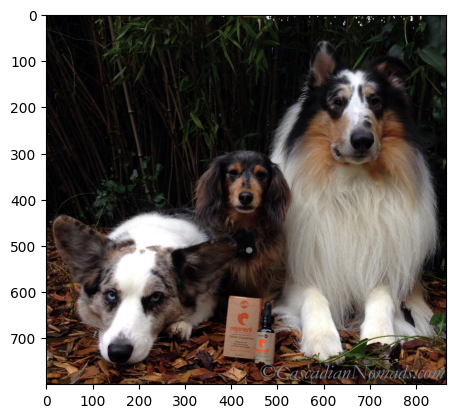

Detected dog breeds: Australian shepherd, Havanese, Collie


In [26]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image

imgsFolder = 'myImages_1/'
for imgFile in os.listdir(imgsFolder):
    img_path = os.path.join(imgsFolder, imgFile)
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # Use the new function that is designed to handle multiple detections
    predicted_breeds = predict_breed_transfer_multi(img_path, model_faster_rcnn, model_transfer)
    # Assuming `predicted_breeds` is the list of breeds you obtained
    unique_breeds = set(predicted_breeds)
    print(f"Detected dog breeds: {', '.join(unique_breeds)}")
